In [1]:
import nilearn
from nilearn import image, plotting
import pandas
import numpy as np
import time
import psutil
from models import batched_linear_regression
from utils.dataloading import NiftiLazyLoader

In [ ]:
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Available (GB):', psutil.virtual_memory()[0]/1000000000)

RAM memory % used: 64.0
RAM Available (GB): 16.03620864


In [ ]:
a = nilearn.image.load_img("../data/test_data/sub-56556_acq-MB2_MNI152NLin2009cAsym_desc-preproc_desc-OD_NODDI.nii")
b = nilearn.image.load_img("../data/test_data/sub-56556_acq-MB2_MNI152NLin2009cAsym_desc-preproc_desc-ICVF_NODDI.nii")
c = nilearn.image.load_img("../data/test_data/sub-56556_acq-MB2_MNI152NLin2009cAsym_desc-preproc_desc-ISOVF_NODDI.nii")
d = nilearn.image.load_img("../data/test_data/highres001_BrainExtractionBrain_trans_prob_1_trans.nii")

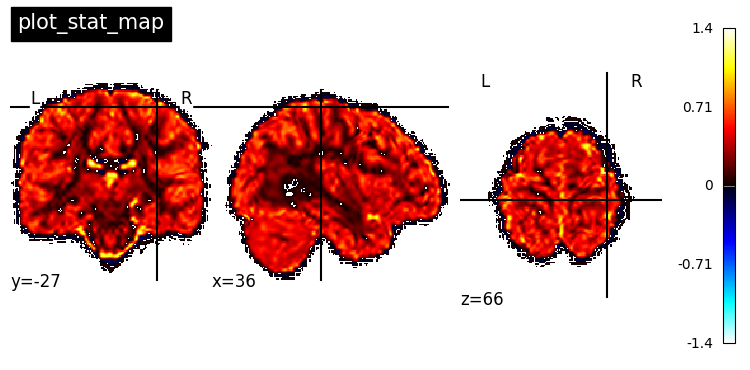

In [5]:
plotting.plot_stat_map(
    a, bg_img=None,title="plot_stat_map", cut_coords=[36, -27, 66], threshold=1e-2
)

In [4]:
# Constants
m = 193*193*229 // 12  # Number of models
n = 200    # Number of data points per dataset
k = 6      # Number of features
lambda_reg = 0.1  # Regularization strength

# Data preparation
# Generate random datasets for all models
X = np.random.randn(m, n, k)  # Shape: (m, n, k)
Y = np.random.randn(m, n)     # Shape: (m, n)

# Add a column of ones to X for the bias term
# New X shape: (m, n, k + 1)
X = np.concatenate([np.ones((m, n, 1)), X], axis=2)

In [6]:
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Available (whole) (GB):', psutil.virtual_memory()[0]/1000000000)
print('RAM Available (GB):', psutil.virtual_memory()[4]/1000000000)

RAM memory % used: 78.1
RAM Available (whole) (GB): 16.03620864
RAM Available (GB): 3.508301824


In [ ]:
# Compute the results

# Compute X^T X and X^T Y for all models in a batch
t0 = time.time()
B = batched_linear_regression(X,Y,lambda_reg)

t1= time.time()
# B contains the coefficients (including bias) for all models
print(f"Shape of coefficients matrix: {B.shape}")  # Expected: (m, k+1)
print(f"Time f64:{t1-t0}")

Shape of coefficients matrix: (710835, 7)
Time f64:46.109721183776855


In [5]:
# Compute the results
X = X.astype(np.float32)
Y = Y.astype(np.float32)

In [ ]:
t0 = time.time()
# Compute X^T X and X^T Y for all models in a batch
B_f32 = batched_linear_regression(X,Y,lambda_reg)
t1 = time.time()
# B contains the coefficients (including bias) for all models
print(f"Shape of coefficients matrix: {B_f32.shape}")  # Expected: (m, k+1)
print(f"Time f32:{t1-t0}")


Shape of coefficients matrix: (710835, 7)
Time f32:33.72251749038696


In [ ]:
del B, B_f32

# Compute the results
X_f16 = X.astype(np.float16)
Y_f16 = Y.astype(np.float16)


In [ ]:
t0 = time.time()
B_f16 = batched_linear_regression(X_f16,Y_f16,lambda_reg)
t1 = time.time()
# B contains the coefficients (including bias) for all models
print(f"Shape of coefficients matrix: {B_f16.shape}")  # Expected: (m, k+1)
print(f"Time f16:{t1-t0}")


KeyboardInterrupt: 

In [10]:
# Define dimensions
# Constants
m = 193*193*229 // 12  # Number of models
n = 200    # Number of data points per dataset
k = 6      # Number of features
lambda_reg = 0.1  # Regularization strength
# Generate random coefficients (including bias)
B_true = np.random.randn(m, k + 1)  # Shape: (m, k+1)

# Generate input features (including bias term)
X = np.random.randn(m, n, k)  # Shape: (m, n, k)
X = np.concatenate([np.ones((m, n, 1)), X], axis=-1)  # Add bias term

# Generate output with some noise
Y = np.einsum('mni,mi->mn', X, B_true) + 0.1 * np.random.randn(m, n)  # Shape: (m, n)

B_pred = batched_linear_regression(X,Y,lambda_reg)


In [2]:
from nilearn import image
import nibabel as nib
import numpy as np
import psutil
from glob import glob
import os
import gzip
import shutil
import pandas as pd

class NiftiLazyLoader(object):
    def __init__(self, data_filename_paterns, column_names_as_data, column_name_target, use_mask, dtype = np.float32, decompress = True):

        if decompress:
            self.extension = ".nii"
            process_subfolders_decompression("../data","sub-*",data_filename_paterns)
            if use_mask is not None:
                process_subfolders_decompression("../data","sub-*",[use_mask])
        else:
            self.extension = ".nii.gz"
        # List the columns you want to read (by name)
        columns_to_read = [*column_names_as_data,column_name_target]  # Replace with the actual column names

        #self.participants_data = pd.read_csv('participants.tsv', sep='\t', usecols=columns_to_read)
        self.data_filename_paterns = data_filename_paterns
        self.dtype = dtype
        self.k = 16  # Initialize k
        self.split_indices = None
        self.parameters = len(data_filename_paterns)

        if use_mask is not None:

            mask = image.load_img("../data/sub-*/"+use_mask+self.extension)

            mask = mask.get_fdata()

            print(f"Mask shape: {mask.shape}")

            # We calculate intersection of all masks
            mask = np.all(mask,axis=-1)

            # TODO implement this for data without mask
            self.mask_shape = mask.shape
            
            # calculate number of elements in mask which are True
            mask_num_el = np.sum(mask)
            #mask_num_el = mask.flatten().shape[0]
            print(f"Mask shape: {mask.shape}, Number of elements in mask: {mask_num_el}, out of {mask.size} elements")

            split_points = np.linspace(0, mask_num_el, self.k + 1, dtype=int)
            self.split_indices = [(split_points[i], split_points[i+1]) for i in range(self.k)] 
            #self.split_indices = np.array_split(mask_num_el, self.k)

        self.mask = mask if use_mask is not None else None
        self.mask_num_el = mask_num_el if use_mask is not None else None
        self.file_paths = []  # Initialize file_paths
        self.current_index = 0  # Initialize current_index
        self.batch_size = 1  # Initialize batch_size
        available_mem = psutil.virtual_memory()[4]

    # # create a generator to load and mask data without loading all elements into memory at once
    # def load_and_mask_data(self, k=1):
    #     data_filename_paterns = self.data_filename_paterns
    #     mask = self.mask
    #     for i in range(k):
    #         for data_filename_patern in data_filename_paterns:
    #             images = image.load_img(f"../../data/sub-*/{data_filename_patern}", dtype=self.dtype)
    #             all_data = []
    #             data = images.get_fdata()

    #             # check if broadcast is working
    #             if mask is not None:
    #                 data = data[mask]
    #             else:
    #                 data = np.reshape(data, (data.shape[0], -1))
    #                 #data = data.flatten(dim=(1,2,3))
    #             part_size = data.shape[1] // k
    #             all_data.append(data[:,i * part_size:(i + 1) * part_size])

    #         all_data = np.stack(all_data,axis=-1)
            
    #         yield all_data
    #         # Indicate the end of the inner loop

    def __next__(self):
        if self.current_index >= self.k:
            raise StopIteration

        data_filename_paterns = self.data_filename_paterns
        mask = self.mask
        all_data = []

        for data_filename_patern in data_filename_paterns:
            images = image.load_img(f"../data/sub-*/{data_filename_patern}"+self.extension, dtype=self.dtype)
            data = images.get_fdata()

            if mask is not None:
                data = data[mask]
            else:
                data = np.reshape(data, (-1,data.shape[-1]))
                if self.split_indices is None:
                    split_points = np.linspace(0, data.shape[0], self.k + 1, dtype=int)
                    self.split_indices = [(split_points[i], split_points[i+1]) for i in range(self.k)] 


            part_size = (data.shape[0] // self.k) + 1
            start, end = self.split_indices[self.current_index]
            all_data.append(data[start:end,:])
            #all_data.append(data[self.current_index * part_size:(self.current_index + 1) * part_size,:])

        all_data = np.stack(all_data, axis=-1)
        self.current_index += 1
        return all_data, self.split_indices[self.current_index-1]
        
    def __iter__(self):
        self.current_index = 0
        return self
    
    def __len__(self):
        return int(self.k)

def decompress_nii_gz(nii_gz_path):
    """Decompress a .nii.gz file and save as .nii in the same folder."""
    nii_path = nii_gz_path.rstrip('.gz')  # Remove the .gz extension
    with gzip.open(nii_gz_path, 'rb') as f_in:
        with open(nii_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    return nii_path

def process_subfolders_decompression(root_folder, folder_pattern, search_terms):
    """
    Process all subfolders matching folder_pattern in root_folder:
    - If a .nii file containing search_terms exists, do nothing.
    - Otherwise, find a .nii.gz file, decompress it, and save it.
    """
    # Find subfolders matching the pattern
    search_path = os.path.join(root_folder, folder_pattern)
    #print(search_path)
    subfolders = [d for d in glob(search_path) if os.path.isdir(d)]
    #print(subfolders)
    
    for folder in subfolders:
        for phrase in search_terms:
            # Search for all matching .nii files (already decompressed)
            nii_pattern = os.path.join(folder, f"{phrase}*.nii")

            nii_files = glob(nii_pattern)
            
            # Search for all matching .nii.gz files
            nii_gz_pattern = os.path.join(folder, f"{phrase}*.nii.gz")
            #print(f"{nii_gz_pattern=},{nii_pattern=}")
            nii_gz_files = glob(nii_gz_pattern)
            #print(nii_files,nii_gz_files)
            if not nii_files:
                decompress_nii_gz(nii_gz_files[0])

In [3]:
dataloader = NiftiLazyLoader(["anat/*MNI152NLin2009cAsym_label*GM_probseg","dwi/*MNI152NLin2009cAsym_desc*OD_NODDI","dwi/*MNI152NLin2009cAsym_desc*ISOVF_NODDI","dwi/*MNI152NLin2009cAsym_desc*ICVF_NODDI"],use_mask="anat/*MNI152NLin2009cAsym_desc*brain_mask",
                             column_name_target=[],column_names_as_data=[])

Mask shape: (193, 229, 193, 2)
Mask shape: (193, 229, 193), Number of elements in mask: 1906256, out of 8530021 elements


In [6]:
from models import batched_irls, batched_ols, batched_ridge
from random_betas_creation import create_random_vector

In [7]:
data_num_el = 193*193*229
a,b,c = dataloader.mask_shape
n_features = dataloader.parameters
mask = dataloader.mask
mask = np.where(mask)
target_betas = create_random_vector(a,b,c,n_features)
target_betas = target_betas[mask]
print(target_betas.shape)

reg_models = [batched_irls, batched_ols, batched_ridge]
output_names = ["irls", "ols", "ridge"]
affine = np.eye(4)

for reg_model,name in zip(reg_models,output_names):
    print(f"Running {name}")
    output_data = np.zeros((a,b,c,n_features+1))

    for data, indices in dataloader:
        #print(data.shape)
        #print(target_betas[indices[0]:indices[1],:].shape)

        #print(np.ones((data.shape[0],1)).shape)

        data_with_bas = np.concatenate((np.ones((data.shape[0],data.shape[1],1)),data),axis=2)

        true_y = np.einsum('mni,mi->mn', data_with_bas, target_betas[indices[0]:indices[1],:])
        #print(true_y.shape)
        b_pred = reg_model(data_with_bas,true_y)
        b_pred = b_pred.squeeze()
        output_data[mask[0][indices[0]:indices[1]], mask[1][indices[0]:indices[1]], mask[2][indices[0]:indices[1]], :] = np.abs(b_pred - target_betas[indices[0]:indices[1], :])
        #output_data[mask][indices[0]:indices[1],:] = np.abs(b_pred-target_betas[indices[0]:indices[1],:])
        #output_data[np.ix_(mask, np.arange(output_data.shape[1]))][indices[0]:indices[1], :] = np.abs(b_pred - target_betas[indices[0]:indices[1], :])
        #print(np.max(np.abs(b_pred-target_betas[indices[0]:indices[1],:])))
        #print(np.max(np.abs(b_pred)))
        #print(output_data[mask][indices[0]:indices[1],:])
        nifti_img = nib.Nifti1Image(output_data, affine)

        # Save using nibabel
        nib.save(nifti_img, "../outputs/"+ name+".nii")
    


(1906256, 5)
Running irls


LinAlgError: Singular matrix

In [ ]:
# saving the data
# Define an affine matrix (identity if no reference image)

# Create a NIfTI image
nifti_img = nib.Nifti1Image(output_data, affine)

# Save using nibabel
nib.save(nifti_img, "../outputs/output2.nii")

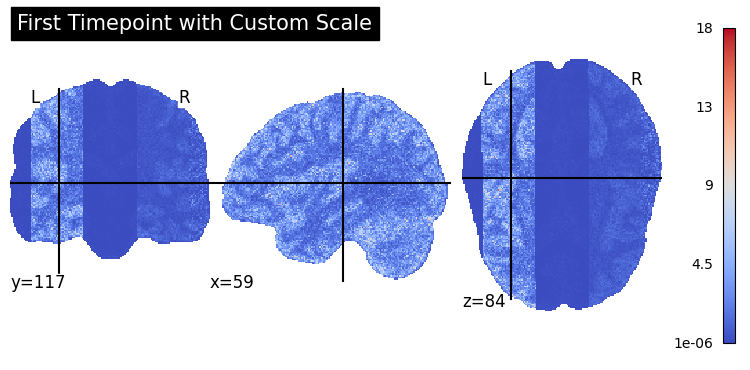

In [54]:
nifti_img = nib.load("../outputs/output2.nii")

# Select a specific time point (e.g., first time point)
first_volume = image.index_img(nifti_img, 0)

# Display the image
#plotting.plot_epi(first_volume, title="First Timepoint")
plotting.plot_stat_map(
    first_volume,
    title="First Timepoint with Custom Scale",
    colorbar=True,
    cmap="coolwarm",
    #vmax=1.0,  # Maximum value
    #vmin=0.0,   # Minimum value
    bg_img=None
)
plotting.show()


## Create a distribution of to create B 
for regression (create gaussian noise and regional noise)
Beta comming from gaussian and uniforms
choose values to differciate between methods ridge and lasso
OLS - ordinary least squares

ridge performs better which multicolinearility

mix the coeficients 

IRLS vs WLS (weighted least square)

check the lilearn options for regression

boostrap crossval